# Image Analysis
The purpose of this script is to analyze the way images are read into
Python vs. MATLAB. This information will be used to analyze images for
multivariate analysis in both languages.


In [1]:
# Import packages
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import Polynomial
from os import listdir
from os.path import join, normpath
import PIL
from scipy.optimize import curve_fit
from scipy.signal import convolve2d
from sys import exit
from tqdm import tqdm

# import local modules
from shapes import Point, Rectangle
from utils import (
    roc_curve, load_roi, search_data, dark_correct,
    ratiometric_fx_1, ratiometric_fx_2, ratiometric_fx_3,
    bandpass_fx_1, bandpass_fx_2
)

# Parameters for Analysis
1. _DATA_PATH =  the root path to the stored datasets.
2. _OUTPUT_PATH = the location to save the data files from an individual run.
3. _RO_PATH = will be used if you would like to load an existing ROI from file.

These paths are checked and stored as a dictionary for easy access later in the script.
<br>

Below the path settings, you will see the dataset parameters. These define which set of images you would like to analyze.
1. _CAM = "VIS" or "SWIR"
2. _SCENE = the scene to be analyzed. (ie: "scene031")
3. _FILTER_SET = "MOE" or "NARROW BANDPASS"
4. _SET_NAME = the set to be analyzed. (ie: "set006")

Next are the fitting parameters.

The _FIT_FUNC parameter should be an integer in [1, 2, 3]. The "NARROW BANDPASS" filter set has 2 functions that can be used, whereas the "MOE" filter set has 3 functions that can be used.
* "NARROW BANDPASS" functions (where $x$ is the Bandpass Ratio Image):
    1. $a*x + b$
    2. $a*x^{2} + b*x + c$
<br>
* "MOE" Functions (where $x, y, z$ == MOE1, MOE2, MOE3)
    1. $a*x + b*y + c*z + d$
    2. $a*x^{2} + b*x + c*y^{2} + d*y + e*z^{2} + f*z + g$
    3. $a*x^{2} + b*x + c*y^{2} + d*y + e*z^{2} + f*Z + g*x*y + h*x*z + i*y*z + j$

Lastly, the image processing settings can be seen.
1. _SMOOTH_KERNEL = kernel size for smoothing.
2. _EROSION_KERNEL = kernel size for erosion.
3. _DILATION_KERNEL = kernel size for dilation.

In [2]:
# Data path settings
_DATA_PATH = normpath(
    r"C:\Users\hsmith\OneDrive - THORLABS Inc\Documents - Thorlabs Spectral Works"
    + r"\Customers\DSTL\S3 Kestrel Vision\Task 3 MOE Imager Testing\3.2 External Testing"
)
_OUTPUT_PATH = normpath(
    r"C:\Users\hsmith\OneDrive - THORLABS Inc\Documents - Thorlabs Spectral Works"
    + r"\Customers\DSTL\S3 Kestrel Vision\Task 3 MOE Imager Testing\3.2 External Testing"
    + r"\Analysis\Visible\test_output"
)
_ROI_PATH = normpath(
    r"C:\Users\hsmith\OneDrive - THORLABS Inc\Documents - Thorlabs Spectral Works"
    + r"\Customers\DSTL\S3 Kestrel Vision\Task 3 MOE Imager Testing\3.2 External Testing"
    + r"\Analysis\Visible\scene031\matlab\roi.txt"
)

# Dataset parameters
_CAM = "VIS"
_SCENE = "scene031"
_FILTER_SET = "MOE"
_SET_NAME = "set006"

# get the path dictionary for use later
_PATH_DICT = search_data(_DATA_PATH, _CAM, _SCENE, _FILTER_SET, _SET_NAME)
print(f'Path Keys: \n{_PATH_DICT.keys()}')

# Fitting parameters
_FIT_FUNC = 1
_MOE_CHOICES = [1, 2, 3]

# Image processing parameters
_SMOOTH_KERNEL = np.ones((15, 15), np.float64)/15**2
_EROSION_KERNEL = 5
_DILATION_KERNEL = 5

Path Keys: 
dict_keys(['root', 'camera', 'scene', 'filter', 'set'])


In [3]:
# Parameters used during drawing ROI's
_DRAWING = False
_IX, _IY = -1,-1
_START_POINT = Point(-1, -1)
_END_POINT = Point(-1, -1)
_OPEN_IMG = None
_TARGET_ROI = []
_NON_TARGET_ROI = []

# define a callback used while drawing an ROI on an open image
def draw_rectangle(event, x, y, flags, param):
    """
    Rectangular mouse callback function.
    """
    global _IX, _IY, _DRAWING, _START_POINT, _END_POINT, _TARGET_ROI, _NON_TARGET_ROI

    if event == cv.EVENT_LBUTTONDOWN:
        _DRAWING = True
        _IX, _IY = x, y

        _START_POINT = Point(_IX, _IY)
        
        print(f'Start Point: {_START_POINT}')

    elif event == cv.EVENT_MOUSEMOVE and _DRAWING:
        tmp = _OPEN_IMG.copy()
        cv.rectangle(tmp, (_IX, _IY), (x,y), (0, 255, 255), 2)
        cv.imshow('Select ROI', tmp)


    elif event == cv.EVENT_LBUTTONUP:
        _DRAWING = False
        clr = (0, 255, 0) if not _TARGET_ROI else (0, 0, 255)
        cv.rectangle(_OPEN_IMG, (_IX, _IY), (x,y), clr, 2)
        cv.imshow('Select ROI', _OPEN_IMG)

        _END_POINT = Point(x, y)
        _ROI = Rectangle(_START_POINT, _END_POINT)

        if not _TARGET_ROI:
            _TARGET_ROI = Rectangle(_START_POINT, _END_POINT)

        elif _TARGET_ROI:
            _NON_TARGET_ROI.append(Rectangle(_START_POINT, _END_POINT))

        print(f'End Point: {_END_POINT}')
        print(f'ROI: {_ROI}')

# Load in the Data
Load in the images for analysis. The images are stored as 16-bit .tif images. First, the images are loaded as raw grayscale images for processing. Next, the images are loaded as RGB images, these are strictly to be used for the purpose of displaying or drawing the color coded ROI regions on the image. 


8 set images found.
	.\20220207_101953_DARK.tif | MIN 4.5777065690089265e-05 | MAX: 0.0014648661020828567 | float64
	.\20220207_101953_NE03B.tif | MIN 0.0004234378576333257 | MAX: 0.06247043564507515 | float64
	.\20220207_101953_VIS_MOE_01-04.tif | MIN 0.0007705806057831693 | MAX: 0.06247043564507515 | float64
	.\20220207_101953_VIS_MOE_02-01.tif | MIN 0.0008125429159990845 | MAX: 0.06247043564507515 | float64
	.\20220207_101953_VIS_MOE_03-01.tif | MIN 0.0007515068284122988 | MAX: 0.06247043564507515 | float64
	.\20220207_101953_VIS_MOE_P001.tif | MIN 0.0007629510948348211 | MAX: 0.06247043564507515 | float64
	.\20220207_101953_VIS_MOE_P002.tif | MIN 0.0007019150072480354 | MAX: 0.058842603189135576 | float64
	.\20220207_101953_VIS_MOE_P003.tif | MIN 0.0007438773174639505 | MAX: 0.06247043564507515 | float64


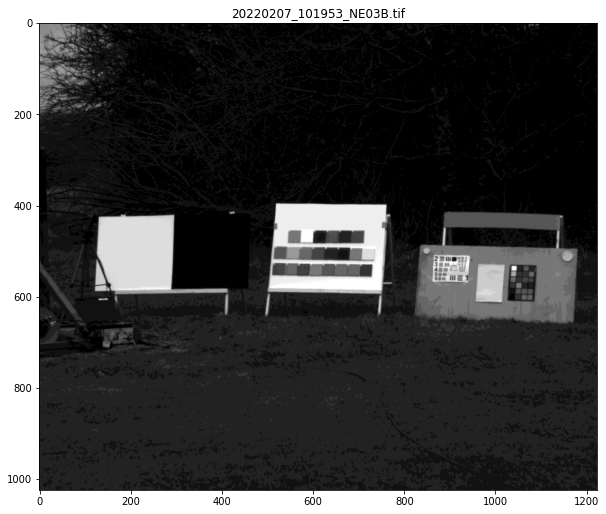

In [4]:
# load in the raw GRAYSCALE image data
grayscale_imgs = {}
for s in listdir(_PATH_DICT['set']):

    if "set_details" not in str(s).lower() and "scene_image" not in str(s).lower():

        temp = cv.imread(join(_PATH_DICT['set'], str(s)), -1)  # read the image
        temp = temp.astype(np.float64) / 65535.0  # scale to floating point
        h, w = temp.shape
        grayscale_imgs[str(s)] = cv.resize(temp, (w//2, h//2))  # reshape

# display the image filenames that are found
print(f'\n{len(grayscale_imgs)} set images found.')
for im, arr in grayscale_imgs.items():
    print(f'\t.\\{im} | MIN {np.min(arr)} | MAX: {np.max(arr)} | {arr.dtype}')

# use a dict to store the RGB images
rgb_images = {}
for im in listdir(_PATH_DICT['set']):

    if ".tif" in str(im).lower() or ".png" in str(im).lower():

        temp = cv.imread(join(_PATH_DICT['set'], str(im)))
        im_height, im_width, im_depth = temp.shape
        rgb_images[str(im)] = cv.resize(temp, (im_width//2, im_height//2))

# normalize an image from the set
_OPEN_IMG = list(rgb_images.values())[1]
_OPEN_IMG = cv.normalize(_OPEN_IMG, dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)
plt.figure(figsize=(10,10))
plt.title(f'{list(rgb_images.keys())[1]}')
plt.imshow(_OPEN_IMG)
plt.show()

# Defining the ROI's
The target ROI is defined as a Rectangle() object using the upper left coordinate and the
lower right coordinate to fully define the ROI. The non-target ROI's are stored as a list
of Rectangles() using the upper left and lower right corners to fully define them. These can be loaded from a text file by providing the path to the existing *roi.txt file.


Target ROI:  [(969, 539), (1009, 539), (969, 599), (1009, 599)]

Non-Target ROIs:  [Rectangle(Point(1149, 504), Point(1169, 519)), Rectangle(Point(1034, 534), Point(1084, 604)), Rectangle(Point(524, 456), Point(739, 481)), Rectangle(Point(519, 496), Point(734, 516)), Rectangle(Point(514, 530), Point(729, 550)), Rectangle(Point(539, 404), Point(754, 424)), Rectangle(Point(749, 269), Point(869, 389)), Rectangle(Point(699, 9), Point(799, 109)), Rectangle(Point(179, 469), Point(249, 539))]


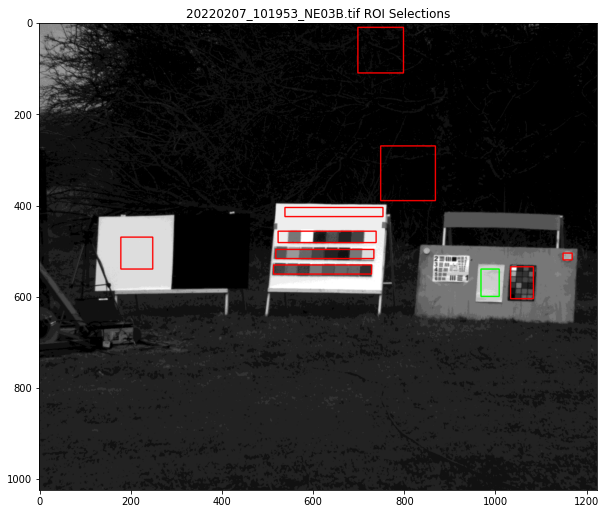

In [5]:
# determine how to handle ROI's
_LOAD_ROI = True

# handle the ROI selection
if _LOAD_ROI:

    # get the ROI regions
    _TARGET_ROI, _NON_TARGET_ROI = load_roi(_ROI_PATH)

    # draw the target ROI on the display image
    cv.rectangle(
        _OPEN_IMG,
        (_TARGET_ROI.point1.x, _TARGET_ROI.point1.y),
        (_TARGET_ROI.point2.x, _TARGET_ROI.point2.y),
        (0, 255, 0), 2
    )

    # draw the non-target ROI's on the display image
    for box in _NON_TARGET_ROI:
        cv.rectangle(
            _OPEN_IMG,
            (box.top_left.x, box.top_left.y),
            (box.bottom_right.x, box.bottom_right.y),
            (255, 0, 0), 2
        )



elif not _LOAD_ROI:

    # use opencv - imshow() to allow ROI selection
    cv.namedWindow("Select ROI")
    cv.setMouseCallback("Select ROI", draw_rectangle)
    while 1:
        cv.imshow(
            "Select ROI",
            _OPEN_IMG
        )
        if cv.waitKey() & 0xFF == 27:
            break
    cv.destroyAllWindows()

print('\nTarget ROI: ', _TARGET_ROI)
print('\nNon-Target ROIs: ', _NON_TARGET_ROI)

plt.figure(figsize=(10,10))
plt.title(f'{list(rgb_images.keys())[1]} ROI Selections')
plt.imshow(_OPEN_IMG)
plt.show()

# Building the Model
Now that the ROI's have been chosen, we can go onto build the prediction model. There are two methods of building the model:

1. Ratio the Narrow Bandpass Images
2. Ratio the MOE and Neutral Density Images

The method to be used is determined by the _FILTER_SET parameter. All of the images must be dark corrected before the model can be built. The equation is defined as:

$I_{Dark Correct} = I - Dark$

Performing dark subtraction..


100%|██████████| 7/7 [00:00<00:00, 304.33it/s]

Dark corrected 7 images.
	.\20220207_101953_NE03B.tif | MIN 0.0003433279926756695 | MAX: 0.062409399557488365 | float64
	.\20220207_101953_VIS_MOE_01-04.tif | MIN 0.000690470740825513 | MAX: 0.06239795529106584 | float64
	.\20220207_101953_VIS_MOE_02-01.tif | MIN 0.0007438773174639506 | MAX: 0.062409399557488365 | float64
	.\20220207_101953_VIS_MOE_03-01.tif | MIN 0.0006637674525062944 | MAX: 0.062409399557488365 | float64
	.\20220207_101953_VIS_MOE_P001.tif | MIN 0.0006752117189288166 | MAX: 0.06240177004654002 | float64
	.\20220207_101953_VIS_MOE_P002.tif | MIN 0.0006294346532387274 | MAX: 0.058758678568703746 | float64
	.\20220207_101953_VIS_MOE_P003.tif | MIN 0.000652323186083772 | MAX: 0.062409399557488365 | float64


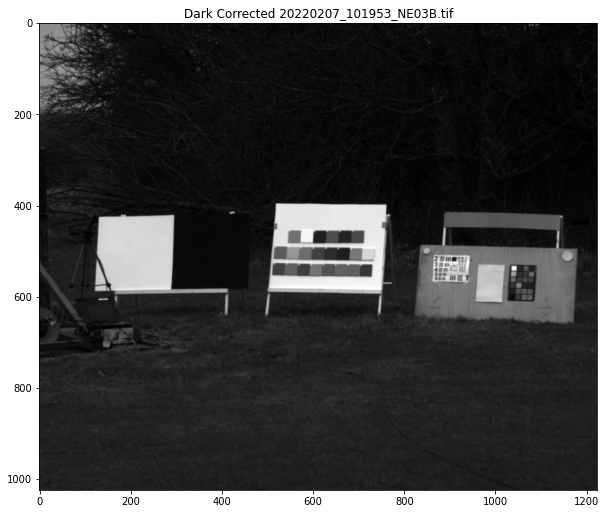

In [6]:
# dark-subtract the images
print('Performing dark subtraction..')
dark_correct_imgs = dark_correct(grayscale_imgs)

# display the dictionary with dark corrected images
# display the images that are found
print(f'Dark corrected {len(dark_correct_imgs)} images.')
for im, arr in dark_correct_imgs.items():
    print(f'\t.\\{im} | MIN {np.min(arr)} | MAX: {np.max(arr)} | {arr.dtype}')

# display one of the dark corrected images
# normalize an image from the set
display_dark = list(dark_correct_imgs.values())[0]
display_dark = cv.normalize(display_dark, dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)
plt.figure(figsize=(10,10))
plt.title(f'Dark Corrected {list(dark_correct_imgs.keys())[0]}')
plt.imshow(display_dark, cmap='gray')
plt.show()

## Bandpass Method
The Narrow Bandpass model can be constructed by first calculating the ratio between the images taken with each of the two bandpass filters:

1. FB580-10
2. FB640-10

Next, the ROI intensities must be extracted from the ratio image. Once that is done, a polynomial fit can be done using on of the two bandpass model functions described in the parameters section. The coefficients from the fit results can be applied to calculate the Receiver Operator Curve (ROC) which extracts the threshold of detection. The detection threshold is then applied to the ratio image to generate a detection image. The detection image can be further processed using erosion and dilation, if necessary.

In [7]:
# build the narrow bandpass model
if _FILTER_SET.upper() == "NARROW BANDPASS":
    print("null")
    

## MOE Method
The MOE model can be built by calculating the ratio between the images taken with the MOE filters and a single image taken with a Neutral Density filter, NE03B. After the ratios are calculated, the same recipe as the Bandpass method can be followed. The main difference is that the fit is done in multiple dimensions rather than a single dimension. 

In [8]:
if _FILTER_SET.upper() == "MOE":

    # the _MOE_CHOICES constant will be used
    # to pick the MOE's to be used in calculations
    moe_key_names = [
        str(list(dark_correct_imgs.keys())[i]) for i in _MOE_CHOICES
    ]

    # pop the ND image from the image dict
    nd_filter = None
    for key in dark_correct_imgs.keys():
        if "NE" in str(key).upper():
            nd_filter = dark_correct_imgs.pop(key)
            break

    # perform ND division on selected MOE's
    moe_nd_images = {}
    print('Calculating MOE/ND ratios..')
    with tqdm(total=len(_MOE_CHOICES)) as pb:
        for k, v in dark_correct_imgs.items():
            if str(k) in moe_key_names:
                moe_nd_images[k] = cv.divide(v, nd_filter)
                pb.update()

    # display the MOE names
    print(f'MOE selections:')
    for name in moe_key_names:
        print(f'\t.\\{name} | MIN {np.min(moe_nd_images[name])} | MAX: {np.max(moe_nd_images[name])} | {moe_nd_images[name].dtype}')


Calculating MOE/ND ratios..


100%|██████████| 3/3 [00:00<00:00, 300.08it/s]

MOE selections:
	.\20220207_101953_VIS_MOE_01-04.tif | MIN 0.22737146994931204 | MAX: 4.842603550295858 | float64
	.\20220207_101953_VIS_MOE_02-01.tif | MIN 0.32078204199855176 | MAX: 3.208695652173913 | float64
	.\20220207_101953_VIS_MOE_03-01.tif | MIN 0.3583888360291786 | MAX: 2.8839285714285716 | float64


In [9]:

if _FILTER_SET.upper() == "MOE":
    # extract the pixel intensities from ROI's
    print('Extracting ROI pixel values..')
    moe_nd_target_class = []
    moe_nd_non_target_class = []

    for img in moe_nd_images.values():
        moe_nd_target_class.append(
            (img[
                    _TARGET_ROI.top_left.y : _TARGET_ROI.bottom_left.y+1,
                    _TARGET_ROI.top_left.x : _TARGET_ROI.top_right.x+1
                ]
            ).flatten()
        )

        moe_nd_non_target_class.append(
            np.concatenate([
                (img[
                    _NON_TARGET_ROI[i].top_left.y : _NON_TARGET_ROI[i].bottom_left.y+1,
                    _NON_TARGET_ROI[i].top_left.x : _NON_TARGET_ROI[i].top_right.x+1
                ]).flatten() for i in range(len(_NON_TARGET_ROI))
            ])
        )

    # convert lists to arrays
    print('Converting pixel data to arrays..')
    moe_nd_target_class = np.asarray(moe_nd_target_class)
    moe_nd_non_target_class = np.asarray(moe_nd_non_target_class)

    print(f'Target: MIN= {np.min(moe_nd_target_class)} | MAX= {np.max(moe_nd_target_class)}')
    print(f'Non-Target: MIN= {np.min(moe_nd_non_target_class)} | MAX= {np.max(moe_nd_non_target_class)}')

    # combine the target/non-targets into X and Y fit data
    moe_nd_x_fit_vals = np.hstack((moe_nd_target_class, moe_nd_non_target_class))
    moe_nd_y_fit_vals = np.hstack((
        np.ones(np.shape(moe_nd_target_class[0])),
        np.zeros(np.shape(moe_nd_non_target_class[0]))
    ))

    print(f'Shape X: {np.shape(moe_nd_x_fit_vals)} \tShape Y: {np.shape(moe_nd_y_fit_vals)}')


Extracting ROI pixel values..
Converting pixel data to arrays..
Target: MIN= 0.9417245735944412 | MAX= 1.035744899708555
Non-Target: MIN= 0.387430099683929 | MAX= 3.208695652173913
Shape X: (3, 55565) 	Shape Y: (55565,)


Selecting fit function..
Fitting the data..
Fit Coefficients: [-0.01911251  0.17464845 -0.3451132   0.260305  ]
Evaluating the prediction function..


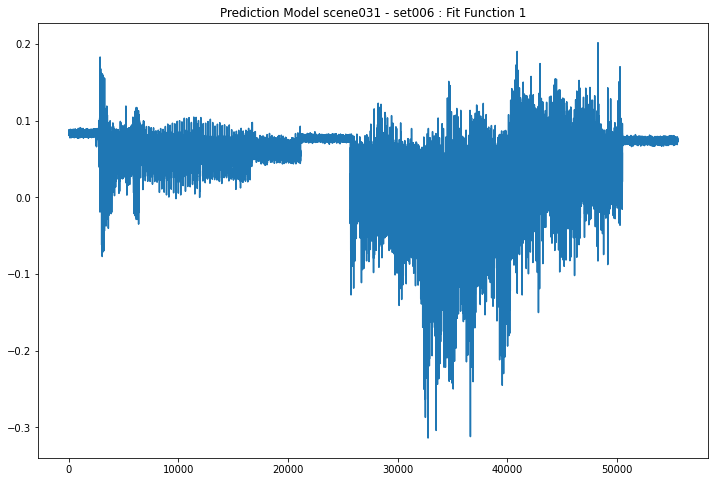

In [10]:
if _FILTER_SET.upper() == "MOE":
    # select the fit function to be used
    print('Selecting fit function..')
    fit_function = None
    if _FIT_FUNC == 1:
        fit_function = ratiometric_fx_1

    elif _FIT_FUNC == 2:
        fit_function = ratiometric_fx_2

    elif _FIT_FUNC == 3:
        fit_function = ratiometric_fx_3

    # fit the data
    print('Fitting the data..')
    moe_nd_opt, moe_nd_cov = curve_fit(
        fit_function, moe_nd_x_fit_vals, moe_nd_y_fit_vals
    )

    print(f'Fit Coefficients: {moe_nd_opt}')

    # calculate the prediction function
    print('Evaluating the prediction function..')
    if _FIT_FUNC == 1:
        moe_nd_predict = np.array([
            fit_function(
                [moe_nd_x_fit_vals[0][i], moe_nd_x_fit_vals[1][i], moe_nd_x_fit_vals[2][i]],
                moe_nd_opt[0],
                moe_nd_opt[1],
                moe_nd_opt[2],
                moe_nd_opt[3]
            ) for i in range(np.shape(moe_nd_x_fit_vals)[1])
        ])

    elif _FIT_FUNC == 2:
        moe_nd_predict = np.array([
            fit_function(
                [moe_nd_x_fit_vals[0][i], moe_nd_x_fit_vals[1][i], moe_nd_x_fit_vals[2][i]],
                moe_nd_opt[0],
                moe_nd_opt[1],
                moe_nd_opt[2],
                moe_nd_opt[3],
                moe_nd_opt[4],
                moe_nd_opt[5],
                moe_nd_opt[6]
            ) for i in range(np.shape(moe_nd_x_fit_vals)[1])
        ])

    elif _FIT_FUNC == 3:
        moe_nd_predict = np.array([
            fit_function(
                [moe_nd_x_fit_vals[0][i], moe_nd_x_fit_vals[1][i], moe_nd_x_fit_vals[2][i]],
                moe_nd_opt[0],
                moe_nd_opt[1],
                moe_nd_opt[2],
                moe_nd_opt[3],
                moe_nd_opt[4],
                moe_nd_opt[5],
                moe_nd_opt[6],
                moe_nd_opt[7],
                moe_nd_opt[8],
                moe_nd_opt[9]
            ) for i in range(np.shape(moe_nd_x_fit_vals)[1])
        ])

    # plot the fit function
    plt.figure(figsize=(12, 8))
    plt.title(f'Prediction Model {_SCENE} - {_SET_NAME} : Fit Function {_FIT_FUNC}')
    plt.plot(moe_nd_predict)
    plt.show()

ROC Threshold: 0.08


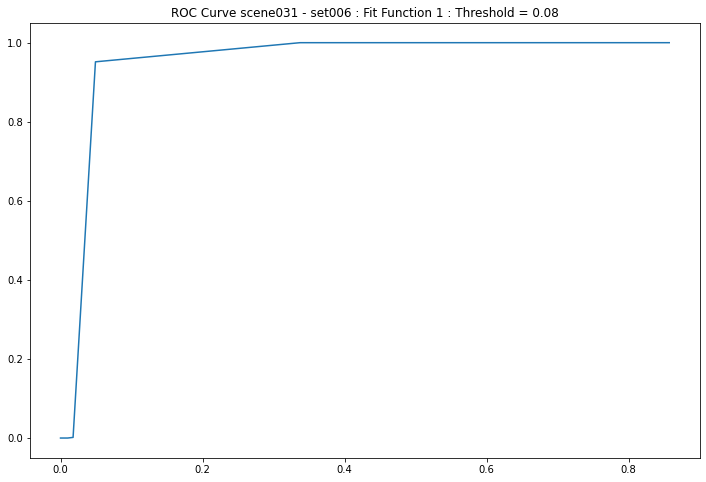

In [11]:
# compute the ROC curve
if _FILTER_SET.upper() == "MOE":
    moe_nd_roc = roc_curve(
        np.reshape(moe_nd_y_fit_vals, (1, len(moe_nd_y_fit_vals))),
        np.reshape(moe_nd_predict, (1, len(moe_nd_predict))),
        np.arange(0, 1, 0.01)
    )

    print(f"ROC Threshold: {moe_nd_roc['t_val']}")

    save_roc = plt.figure(figsize=(12,8))
    ax = plt.subplot(111)
    ax.plot(moe_nd_roc['Pfa'][0], moe_nd_roc['Pd'][0])
    plt.title(f'ROC Curve {_SCENE} - {_SET_NAME} : Fit Function {_FIT_FUNC} : Threshold = {moe_nd_roc["t_val"]}')
    plt.show()

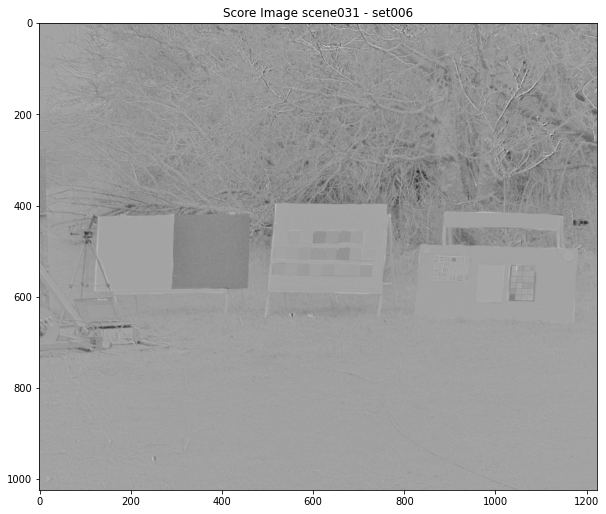

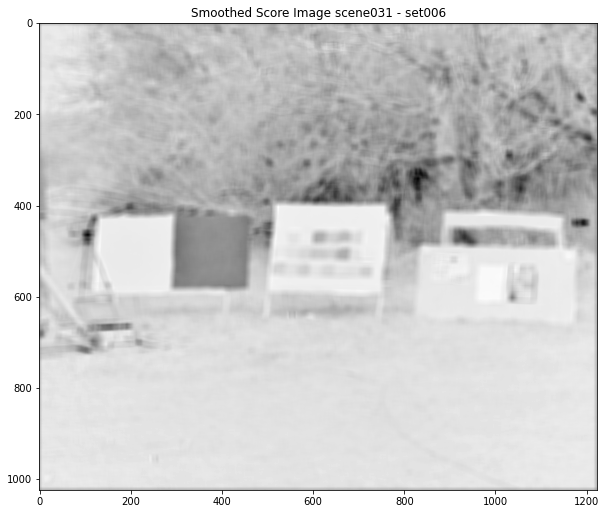

In [12]:
# generate the score image using the fit function
if _FILTER_SET.upper() == "MOE":
    moe_nd_score = None
    with np.errstate(invalid='ignore'):
        ratio_func = np.vectorize(fit_function, excluded=['data'])


        if _FIT_FUNC == 1:
            moe_nd_score = ratio_func(
                data=np.array([
                    list(moe_nd_images.values())[0].flatten(),
                    list(moe_nd_images.values())[1].flatten(),
                    list(moe_nd_images.values())[2].flatten()
                ]),
                a=moe_nd_opt[0],
                b=moe_nd_opt[1],
                c=moe_nd_opt[2],
                d=moe_nd_opt[3]
            )


        elif _FIT_FUNC == 2:
            moe_nd_score = ratio_func(
                data=np.array([
                    list(moe_nd_images.values())[0].flatten(),
                    list(moe_nd_images.values())[1].flatten(),
                    list(moe_nd_images.values())[2].flatten()
                ]),
                a=moe_nd_opt[0],
                b=moe_nd_opt[1],
                c=moe_nd_opt[2],
                d=moe_nd_opt[3],
                e=moe_nd_opt[4],
                f=moe_nd_opt[5],
                g=moe_nd_opt[6]
            )

        elif _FIT_FUNC == 3:
            moe_nd_score = ratio_func(
                data=np.array([
                    list(moe_nd_images.values())[0].flatten(),
                    list(moe_nd_images.values())[1].flatten(),
                    list(moe_nd_images.values())[2].flatten()
                ]),
                a=moe_nd_opt[0],
                b=moe_nd_opt[1],
                c=moe_nd_opt[2],
                d=moe_nd_opt[3],
                e=moe_nd_opt[4],
                f=moe_nd_opt[5],
                g=moe_nd_opt[6],
                h=moe_nd_opt[7],
                i=moe_nd_opt[8],
                j=moe_nd_opt[9]
            )


        moe_nd_score = np.reshape(moe_nd_score, np.shape(list(moe_nd_images.values())[0]))

    plt.figure(figsize=(10,10))
    plt.title(f'Score Image {_SCENE} - {_SET_NAME}')
    plt.imshow(moe_nd_score, cmap='gray')
    plt.show()

    # smooth the score image
    moe_nd_smooth = convolve2d(moe_nd_score, _SMOOTH_KERNEL, mode='same')
    plt.figure(figsize=(10,10))
    plt.title(f'Smoothed Score Image {_SCENE} - {_SET_NAME}')
    plt.imshow(moe_nd_smooth, cmap='gray')
    plt.show()

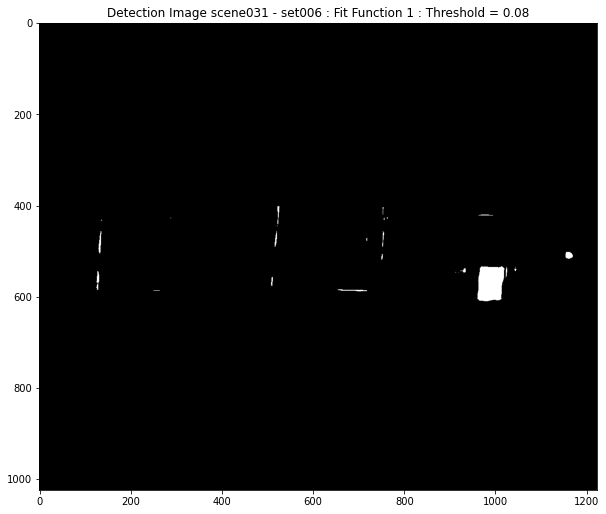

In [13]:
# calculate the detection image
if _FILTER_SET.upper() == "MOE":
    moe_nd_ret, moe_nd_thresh = cv.threshold(
        moe_nd_smooth, moe_nd_roc['t_val'], 1, cv.THRESH_BINARY
    )
    plt.figure(figsize=(10,10))
    plt.title(f'Detection Image {_SCENE} - {_SET_NAME} : Fit Function {_FIT_FUNC} : Threshold = {moe_nd_roc["t_val"]}')
    plt.imshow(moe_nd_thresh, cmap='gray')
    plt.show()